In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from ad99 import AlexanderDunkerton1999
from constants import GRAV,R_DRY,C_P

## Load MiMA sim data + Loon masks

In [6]:
ds = xr.open_dataset('data/atmos_daily.nc')
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')
ds

<xarray.Dataset> Size: 6GB
Dimensions:    (phalf: 41, time: 720, lon: 128, lonb: 129, lat: 64, latb: 65,
                pfull: 40)
Coordinates:
  * phalf      (phalf) float32 164B 0.0 0.4844 0.6312 ... 863.5 941.4 1e+03
  * time       (time) object 6kB 0021-01-02 00:00:00 ... 0023-01-01 00:00:00
  * lon        (lon) float32 512B 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb       (lonb) float32 516B -1.406 1.406 4.219 ... 353.0 355.8 358.6
  * lat        (lat) float32 256B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * latb       (latb) float32 260B -90.0 -86.58 -83.76 ... 83.76 86.58 90.0
  * pfull      (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
Data variables:
    bk         (phalf) float32 164B ...
    pk         (phalf) float32 164B ...
    ps         (time, lat, lon) float32 24MB ...
    ucomp      (time, pfull, lat, lon) float32 944MB ...
    temp       (time, pfull, lat, lon) float32 944MB ...
    vcomp      (time, pfull, lat, lon) float32 944MB ...
    height     (time, pfull, lat, lon) float32 944MB ...
    gwfu_cgwd  (time, pfull, lat, lon) float32 944MB ...
    gwfv_cgwd  (time, pfull, lat, lon) float32 944MB ...
Attributes:
    filename:  atmos_daily.nc
    title:     MiMA
    history:   Fri Jan 17 11:17:31 2025: ncatted -O -a calendar_type,time,o,c...
    NCO:       netCDF Operators version 5.3.1 (Homepage = http://nco.sf.net, ...

In [7]:
ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')

In [8]:
interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)
interp_mask

<xarray.Dataset> Size: 50kB
Dimensions:                 (lat: 64, lon: 128)
Coordinates:
  * lat                     (lat) float32 256B -87.86 -85.1 ... 85.1 87.86
  * lon                     (lon) float32 512B 0.0 2.812 5.625 ... 354.4 357.2
Data variables:
    tropical_atlantic       (lat, lon) bool 8kB False False ... False False
    extratropical_atlantic  (lat, lon) bool 8kB False False ... False False
    extratropical_pacific   (lat, lon) bool 8kB False False ... False False
    indian                  (lat, lon) bool 8kB False False ... False False
    tropical_pacific        (lat, lon) bool 8kB False False ... False False
    southern_ocean          (lat, lon) bool 8kB False False ... False False

In [18]:
ocean_expac = ds.where(interp_mask.extratropical_pacific).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')

In [19]:
ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd']]

In [20]:
ocean_expac = ocean_expac.transpose('time','points','pfull')

In [21]:
us = ocean_expac.ucomp.values[::,:,::-1]
zs = ocean_expac.height.values[::,:,::-1]
temps= ocean_expac.temp.values[::,:,::-1]

gwfu = ocean_expac.gwfu_cgwd.values[::,:,::-1]
gwfv = ocean_expac.gwfv_cgwd.values[::,:,::-1]
pfull = ocean_expac.pfull.values[::-1]

## determine values needed for ad99
TODO: Clean this up!

In [13]:

dTdz = np.gradient(temps,axis=-1)/np.gradient(zs,axis=-1)
Ns2 = GRAV/temps*(dTdz + GRAV/C_P) 
bflim = 1e-4 
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = np.sqrt(Ns2)
rho = (100*pfull.reshape((1,1,-1)))/(R_DRY*temps)

In [22]:
gwfu_ptv = np.where(gwfu > 0,gwfu,0)
uw_mima_ptv = -1*cumulative_trapezoid(rho[...,::-1]*gwfu_ptv[...,::-1],x=zs[...,::-1],initial=0)[...,::-1]

## Run AD99 on MiMA u profiles 

In [23]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm 
gwd = np.zeros_like(us)
uw_ptv = np.zeros_like(us)
uw_ntv = np.zeros_like(us)

def get_ad99(i,j,ad99):
    gwd = ad99.gwd(us[i,j],Ns[i,j],zs[i,j],rho[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,zs[i,j],rho[i,j])
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,zs[i,j],rho[i,j])
    return i,j,gwd,uw_ptv,uw_ntv

ad99 = AlexanderDunkerton1999(source_level_height=9e3,damp_top=True)
results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(us.shape[0]) for j in range(us.shape[1]))

for i,j,gwd_val,uw_ptv_val,uw_ntv_val in results:
    gwd[i,j] = gwd_val
    uw_ptv[i,j] = uw_ptv_val
    uw_ntv[i,j] = uw_ntv_val

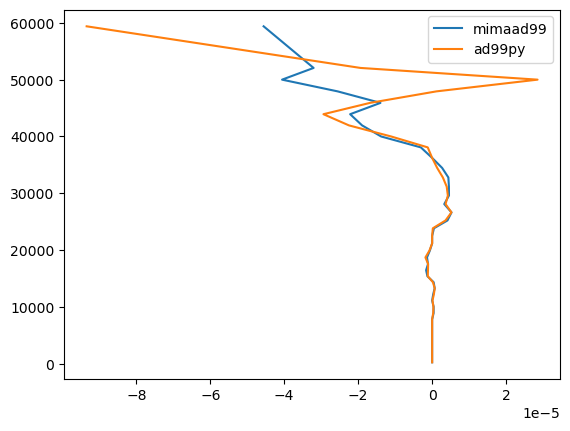

In [24]:
import matplotlib.pyplot as plt 
point = 43
plt.plot(gwfu[0,point],zs[0,point],label="mimaad99")
plt.plot(gwd[0,point],zs[0,point],label="ad99py")
plt.legend()

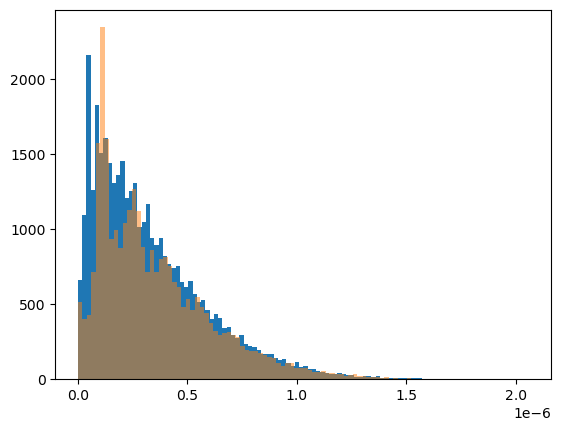

In [78]:
gwd_top = gwd[:,:,15] 
gwfu_top = gwfu[:,:,15] 
gwd_top_ptv = gwd_top[gwd_top > 0]
gwfu_top_ptv = gwfu_top[gwfu_top > 0]
plt.hist(gwd_top_ptv.flatten(),bins=100)
plt.hist(gwfu_top_ptv.flatten(),bins=100,alpha=0.5)
print()

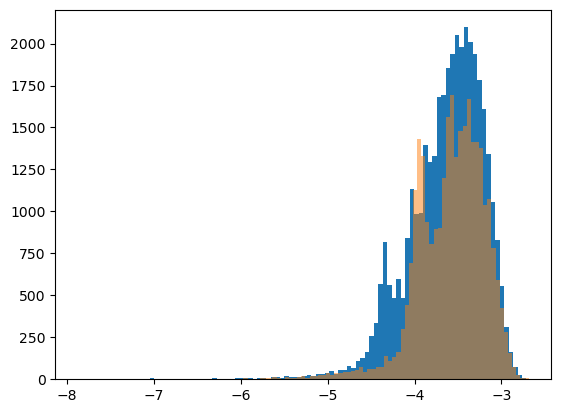

In [79]:
plt.hist(np.log10(gwd_top_ptv.flatten()*1000),bins=100)
plt.hist(np.log10(gwfu_top_ptv.flatten()*1000),bins=100,alpha=0.5)
print()

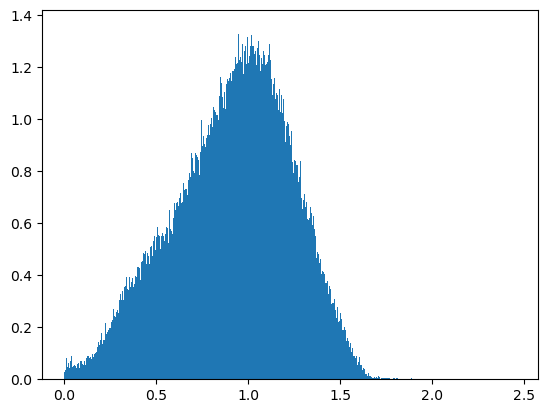

In [80]:
uw_ptv_lvl = uw_ptv[:,:,15].ravel()
uw_ptv_lvl = uw_ptv_lvl[uw_ptv_lvl > 0] * 1000 
plt.hist(uw_ptv_lvl,bins=1000,density=True)
print()

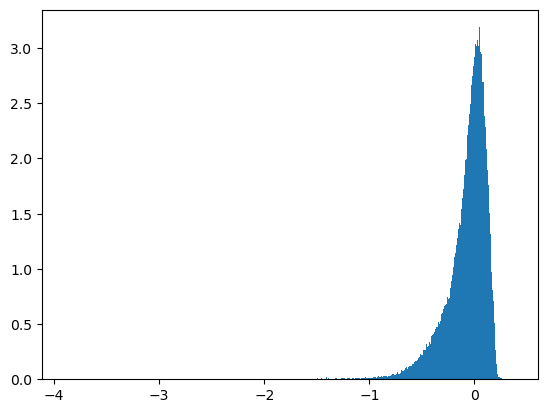

In [81]:
plt.hist(np.log10(uw_ptv_lvl),bins=1000,density=True)
print()

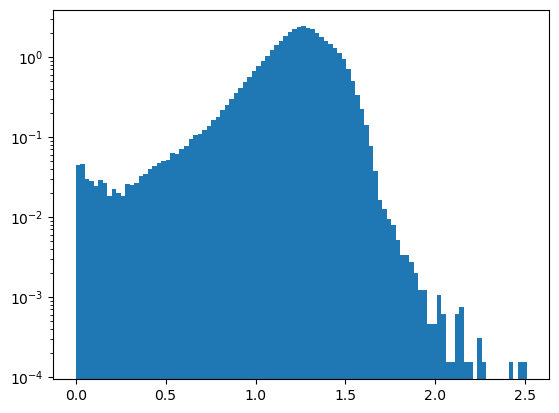

In [ ]:
plt.hist(uw_ptv_lvl,bins=100,density=True)
plt.yscale('log')


(array([9.55406497e-04, 2.59324603e-03, 5.32297941e-03, 6.41487090e-03,
        9.28109231e-03, 9.96352557e-03, 1.35121785e-02, 1.69243357e-02,
        2.47040973e-02, 2.25202854e-02, 3.03000203e-02, 3.63054689e-02,
        4.64054366e-02, 4.38122388e-02, 4.89986815e-02, 5.54136104e-02,
        6.27838259e-02, 6.94716683e-02, 7.64325661e-02, 8.68055572e-02,
        9.52675288e-02, 1.06459646e-01, 1.31300230e-01, 1.40717510e-01,
        1.60235415e-01, 1.75248955e-01, 1.96267911e-01, 2.13874237e-01,
        2.54547742e-01, 2.84165362e-01, 3.05456633e-01, 3.49406017e-01,
        3.93491229e-01, 4.60778191e-01, 4.99131954e-01, 5.67920039e-01,
        6.17740250e-01, 6.89256477e-01, 7.86161843e-01, 8.64781755e-01,
        9.37661781e-01, 1.03307025e+00, 1.11727792e+00, 1.17555763e+00,
        1.25963870e+00, 1.35121567e+00, 1.39530078e+00, 1.44198536e+00,
        1.49261561e+00, 1.52714668e+00, 1.49890045e+00, 1.49862101e+00,
        1.43747509e+00, 1.38329594e+00, 1.29143461e+00, 1.196713

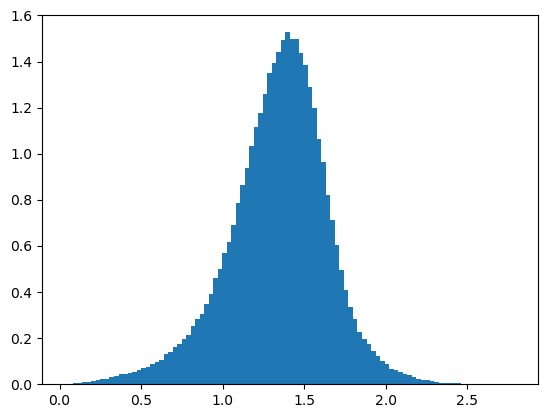

In [47]:
uw_mima_ptv_lvl = uw_mima_ptv[:,:,10].ravel()
uw_mima_ptv_lvl = uw_mima_ptv_lvl[uw_mima_ptv_lvl > 0] * 1000
plt.hist(uw_mima_ptv_lvl,bins=100,density=True)

In [48]:
zs[0,0]

array([  265.0619,   885.5803,  1671.2618,  2558.3618,  3517.7183,
        4531.717 ,  5587.2104,  6672.187 ,  7774.305 ,  8883.92  ,
        9992.183 , 11092.273 , 12179.017 , 13245.033 , 14294.701 ,
       15351.485 , 16429.861 , 17539.734 , 18703.33  , 19922.639 ,
       21191.365 , 22508.23  , 23864.63  , 25251.898 , 26671.582 ,
       28129.713 , 29631.094 , 31183.303 , 32790.82  , 34465.45  ,
       36221.27  , 38066.188 , 39994.36  , 41965.95  , 43941.266 ,
       45928.062 , 47956.043 , 50021.97  , 52035.02  , 59441.78  ],
      dtype=float32)

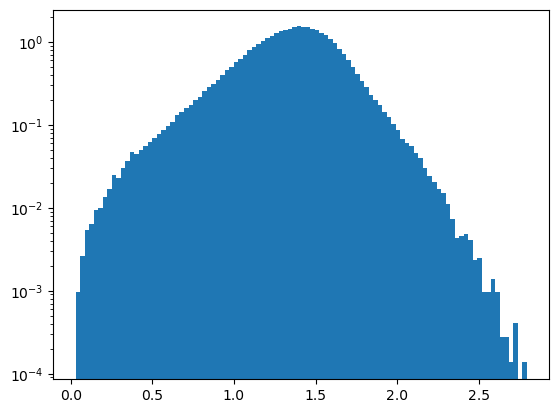

In [49]:
plt.hist(uw_mima_ptv_lvl,bins=100,density=True)
plt.yscale('log')

In [50]:
uw_mima_ptv_lvl.mean()

1.3400799

In [51]:
uw_ptv_lvl.mean()

1.2162313

## Calculate AD99py fluxe distr. skew/variance

In [55]:
uw_ptv_lvl = uw_ptv[...,-15]*1000

In [59]:
def variance_and_skew(x):
    
    mean = np.nanmean(x,axis=-1,keepdims=True)
    var = np.nanmean((x - mean)**2,axis=-1,keepdims=True)
    skew = np.nanmean(((x - mean)/np.sqrt(var))**3,axis=-1)
    return np.squeeze(var,axis=-1),skew



vars,skews = variance_and_skew(uw_ptv_lvl)
log_mpa = np.log10(uw_ptv_lvl)
log_mpa[np.isneginf(log_mpa)] = np.nan
log_vars,log_skew = variance_and_skew(log_mpa)

/var/folders/58/1mynp4bn1pg61mc1j6p3nnxc0000gp/T/ipykernel_5765/1840823633.py:11: RuntimeWarning: divide by zero encountered in log10
  log_mpa = np.log10(uw_ptv_lvl)


## Loon fluxes skew/var

In [60]:
extratrop_pacific_fluxes = np.load('/Users/robcking/PhD/loon_GW_mom_flux/extra_pac_flights_flux.npy')
extratrop_pacific_fluxes_ptv = extratrop_pacific_fluxes[1]

var_loon,skew_loon = variance_and_skew(extratrop_pacific_fluxes_ptv)
log_loon = np.log10(extratrop_pacific_fluxes_ptv)
log_loon[np.isneginf(log_loon)] = np.nan
var_log_loon,skew_log_loon = variance_and_skew(log_loon)

/var/folders/58/1mynp4bn1pg61mc1j6p3nnxc0000gp/T/ipykernel_5765/4091979419.py:5: RuntimeWarning: divide by zero encountered in log10
  log_loon = np.log10(extratrop_pacific_fluxes_ptv)


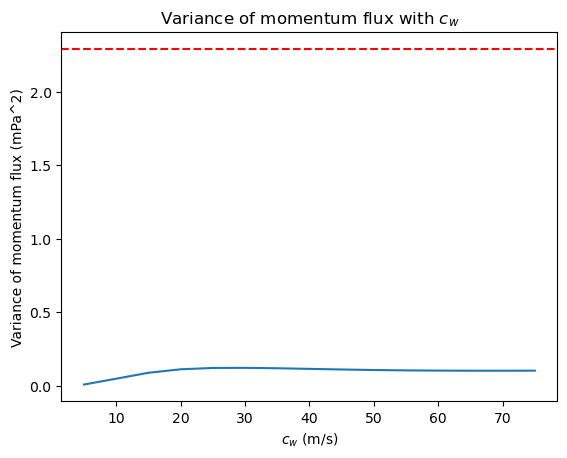

In [82]:
plt.plot(cws,vars)
plt.xlabel('$c_w$ (m/s)')
plt.ylabel("Variance of momentum flux (mPa^2)")
plt.title("Variance of momentum flux with $c_w$")
plt.axhline(var_loon,color='r',label='Loon',linestyle='--')

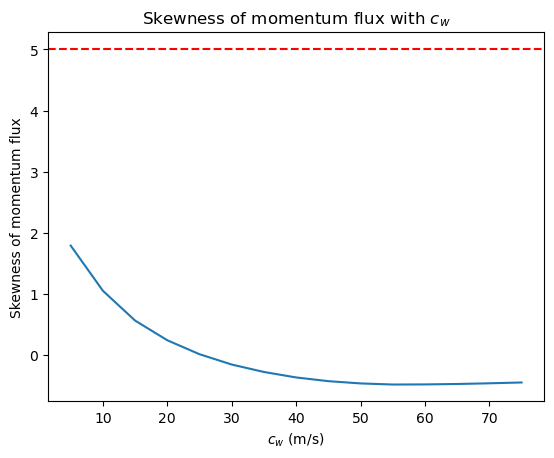

In [83]:
plt.plot(cws,skews)
plt.xlabel('$c_w$ (m/s)')
plt.ylabel("Skewness of momentum flux")
plt.title("Skewness of momentum flux with $c_w$")
plt.axhline(skew_loon,color='r',label='Loon',linestyle='--')    

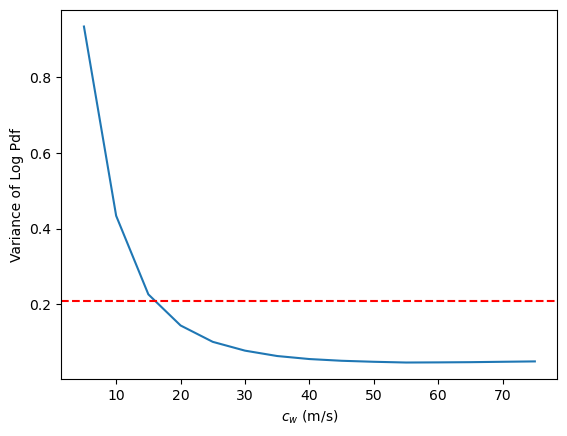

In [84]:
plt.plot(cws,log_vars)
plt.xlabel("$c_w$ (m/s)")
plt.ylabel("Variance of Log Pdf")
plt.axhline(var_log_loon,color='r',label='Loon',linestyle='--') 

Text(0, 0.5, 'Skew of Log Pdf')

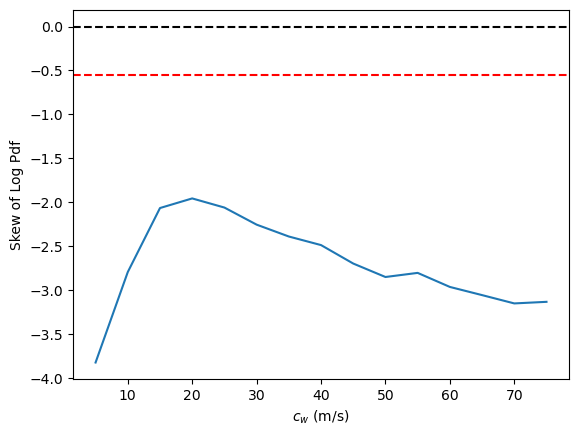

In [86]:
plt.plot(cws,log_skew)
plt.axhline(0,color='k',linestyle='--')
plt.xlabel("$c_w$ (m/s)")
plt.axhline(skew_log_loon,color='r',label='Loon',linestyle='--')
plt.ylabel("Skew of Log Pdf")

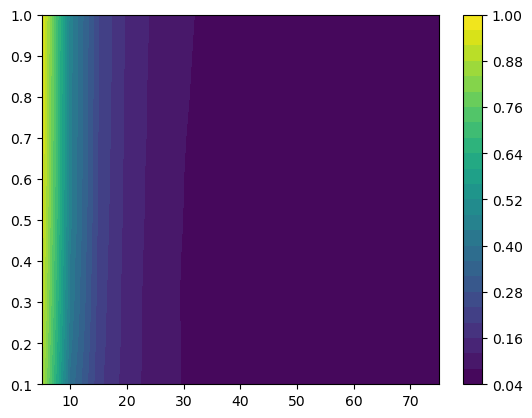

In [123]:
CW, BM = np.meshgrid(cws,bms)

plt.contourf(CW,BM,log_vars,levels=25)
plt.colorbar()

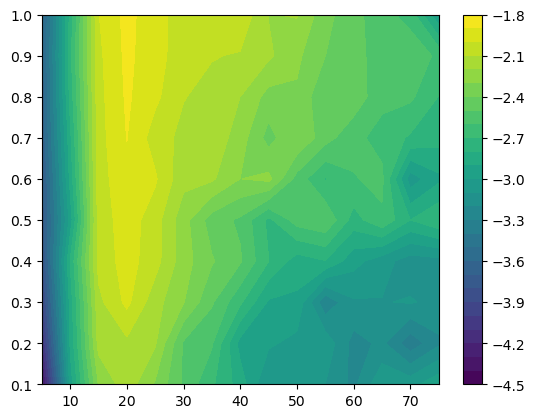

In [124]:
CW, BM = np.meshgrid(cws,bms)

plt.contourf(CW,BM,log_skew,levels=25)
plt.colorbar()

Text(0.5, 1.0, 'Log10 (mPa GW stress) - with source intermittency')

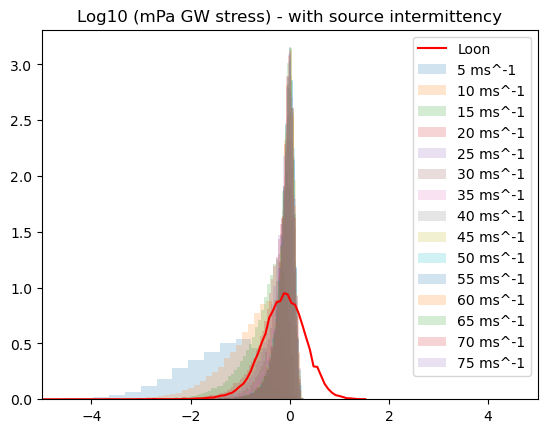

In [93]:
loon_bin_heights,loon_bin_edges = np.histogram(log_loon[~np.isnan(log_loon)],bins=100,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')
for i,c in enumerate(cws):
    plt.hist(log_mpa[i],bins=100,alpha=0.2,label=f"{c} ms^-1",density=True)
    plt.legend()
plt.xlim(-5,5)
plt.title("Log10 (mPa GW stress) - with source intermittency")

## ERA 5

In [62]:
ds_era5 = xr.open_dataset('data/era52015.grib',engine='cfgrib')

Ignoring index file 'data/era52015.grib.5b7b6.idx' incompatible with GRIB file


In [63]:
ds_era5 = ds_era5.stack(points = ['latitude','longitude'])
ds_era5 = ds_era5.transpose('time','points','isobaricInhPa')


In [64]:
ds_era5

<xarray.Dataset> Size: 3GB
Dimensions:        (time: 365, isobaricInhPa: 21, points: 32421)
Coordinates:
    number         int64 8B ...
  * time           (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-...
    step           timedelta64[ns] 8B ...
  * isobaricInhPa  (isobaricInhPa) float64 168B 450.0 400.0 350.0 ... 2.0 1.0
    valid_time     (time) datetime64[ns] 3kB ...
  * points         (points) object 259kB MultiIndex
  * latitude       (points) float64 259kB 15.0 15.0 15.0 ... -10.0 -10.0 -10.0
  * longitude      (points) float64 259kB -180.0 -179.8 -179.5 ... -100.2 -100.0
Data variables:
    z              (time, points, isobaricInhPa) float32 994MB 6.582e+04 ... ...
    t              (time, points, isobaricInhPa) float32 994MB 264.9 ... 260.4
    u              (time, points, isobaricInhPa) float32 994MB -8.308 ... -67.78
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-10T14:22 GRIB to CDM+CF via cfgrib-0.9.1...

In [66]:
era_u = ds_era5.u.values
era_z = ds_era5.z.values/GRAV
era_temp = ds_era5.t.values
era_p = ds_era5.isobaricInhPa*100

era_dTdz = np.gradient(era_temp,axis=-1)/np.gradient(era_z,axis=-1)
era_Ns2 = GRAV/era_temp*(era_dTdz + GRAV/C_P) 
bflim = 1e-4 
era_Ns2 = xr.where(era_Ns2 < bflim**2,bflim**2,era_Ns2)
era_Ns = np.sqrt(era_Ns2)
era_rho = (era_p.values.reshape((1,1,-1)))/(R_DRY*era_temp)

In [67]:
from joblib import Parallel, delayed

era5_gwd = np.zeros_like(era_u)
era5_uw_ptv = np.zeros_like(era_u)
era5_uw_ntv = np.zeros_like(era_u)

def get_ad99(i,j,ad99:AlexanderDunkerton1999):
    gwd = ad99.gwd(era_u[i,j],era_Ns[i,j],era_z[i,j],era_rho[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,era_z[i,j],era_rho[i,j])    
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,era_z[i,j],era_rho[i,j])    
    return i,j,gwd,uw_ptv,uw_ntv

ad99 = AlexanderDunkerton1999(source_level_height=9e3,damp_top=True,base_wavelength=30e3) # smaller grid, smaller wavelength
results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(era_u.shape[0]) for j in range(era_u.shape[1]))

for i,j,era_gwd_val,era_uw_ptv_val,era_uw_ntv_val in results:
    era5_gwd[i,j] = era_gwd_val
    era5_uw_ptv[i,j] = era_uw_ptv_val
    era5_uw_ntv[i,j] = era_uw_ntv_val

In [68]:
np.save('era5_gwd.npy',era5_gwd)
np.save('era5_uw_ptv.npy',era5_uw_ptv)
np.save('era5_uw_ntv.npy',era5_uw_ntv)  

In [39]:
import os 
if os.path.exists("era5_gwd.npy"):
    era5_gwd = np.load("era5_gwd.npy")
if os.path.exists("era5_uw_ntv.npy"):
    era5_uw_ntv = np.load("era5_uw_ntv.npy")
if os.path.exists("era5_uw_ptv.npy"):
    era5_uw_ptv = np.load("era5_uw_ptv.npy")


In [69]:
era5_uw_ptv_lvl = era5_uw_ptv[...,int(np.argmin(np.abs(ds_era5.isobaricInhPa.values - 10)))].ravel()
era5_uw_ptv_lvl = era5_uw_ptv_lvl[era5_uw_ptv_lvl > 0]
era5_uw_ntv_lvl = era5_uw_ntv[...,int(np.argmin(np.abs(ds_era5.isobaricInhPa.values - 10)))].ravel()
era5_uw_ntv_lvl = -1*era5_uw_ntv_lvl[era5_uw_ntv_lvl < 0]

(array([1.72153865e+00, 2.02393892e+00, 1.88713701e+00, 1.71491919e+00,
        1.61339919e+00, 1.53842729e+00, 1.46502637e+00, 1.41079751e+00,
        1.35091326e+00, 1.33278592e+00, 1.31371744e+00, 1.30095286e+00,
        1.29327173e+00, 1.27415630e+00, 1.27147764e+00, 1.26019682e+00,
        1.24377609e+00, 1.23518465e+00, 1.22418952e+00, 1.20871747e+00,
        1.19929460e+00, 1.18653872e+00, 1.17542298e+00, 1.15810686e+00,
        1.14365277e+00, 1.12218483e+00, 1.09033468e+00, 1.07468497e+00,
        1.05115797e+00, 1.02472999e+00, 1.00236469e+00, 9.70186165e-01,
        9.37845738e-01, 9.09132498e-01, 8.76250761e-01, 8.43987747e-01,
        8.15449906e-01, 7.78587171e-01, 7.37215705e-01, 7.09075057e-01,
        6.67964209e-01, 6.34139921e-01, 5.96850210e-01, 5.60654454e-01,
        5.22069386e-01, 4.77127893e-01, 4.36265326e-01, 3.96747151e-01,
        3.60546729e-01, 3.24812380e-01, 2.90973240e-01, 2.57785395e-01,
        2.28659516e-01, 2.00224978e-01, 1.74397983e-01, 1.524609

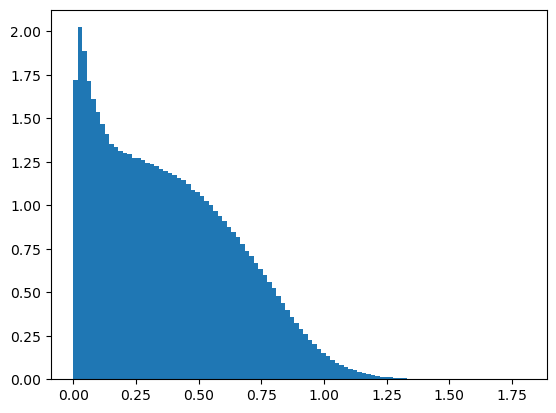

In [70]:
plt.hist(era5_uw_ptv_lvl*1000,bins=100,density=True)


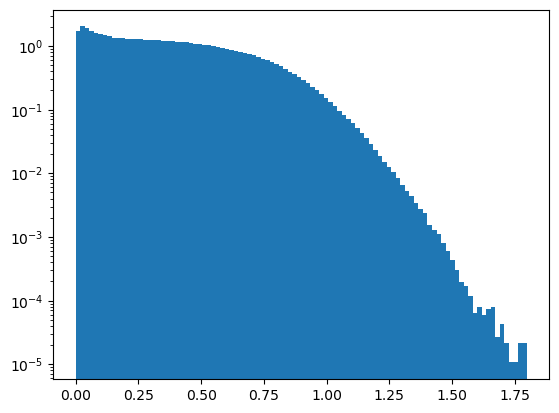

In [71]:
import matplotlib.pyplot as plt
plt.hist(era5_uw_ptv_lvl*1000,bins=100,density=True)
plt.yscale("log")

(array([1.07976816e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.07976247e-06, 1.07976816e-06, 0.00000000e+00, 3.23928742e-06,
        2.15953631e-06, 0.00000000e+00, 3.23930447e-06, 3.23928742e-06,
        8.63814525e-06, 8.63814525e-06, 4.31904989e-06, 9.71791340e-06,
        8.63814525e-06, 9.71791340e-06, 1.61964371e-05, 1.83560587e-05,
        2.15953631e-05, 3.13132765e-05, 2.15952495e-05, 4.42704944e-05,
        4.53502626e-05, 4.21107364e-05, 6.37063212e-05, 6.04670167e-05,
        9.93386704e-05, 1.09056010e-04, 1.10136352e-04, 1.25253106e-04,
        1.52246509e-04, 1.78161746e-04, 1.99757109e-04, 2.53745517e-04,
        2.68860856e-04, 3.75759318e-04, 3.63881869e-04, 4.53502626e-04,
        4.95610975e-04, 5.46362687e-04, 7.32080883e-04, 8.389798

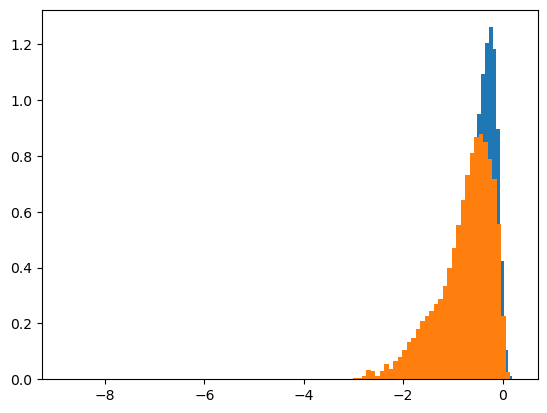

In [72]:
plt.hist(np.log10(1000*era5_uw_ptv_lvl),bins=100,density=True)
plt.hist(np.log10(1000*era5_uw_ntv_lvl),bins=100,density=True)

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 3.000000e+00,
        2.000000e+00, 3.000000e+00, 1.000000e+00, 0.000000e+00,
        1.000000e+00, 2.000000e+00, 5.000000e+00, 1.000000e+00,
        3.000000e+00, 7.000000e+00, 6.000000e+00, 7.000000e+00,
        1.200000e+01, 1.100000e+01, 1.500000e+01, 2.100000e+01,
        1.900000e+01, 2.600000e+01, 2.900000e+01, 2.900000e+01,
        2.900000e+01, 4.800000e+01, 5.300000e+01, 6.500000e+01,
        5.900000e+01, 7.700000e+01, 9.800000e+01, 8.800000e+01,
        1.180000e+02, 1.490000e+02, 1.900000e+02, 1.970000e+02,
        2.330000e+02, 3.020000e+02, 3.000000e+02, 3.730000e+02,
        4.450000e+02, 4.990000e+02, 6.080000e+02, 6.640000e+02,
        7.750000e+02, 9.240000e+02, 1.063000e+03, 1.222000e+03,
        1.505000e+03, 1.778000e+03, 2.395000e+03, 3.164000e+03,
        4.172000e+03, 5.729000e+03, 5.52

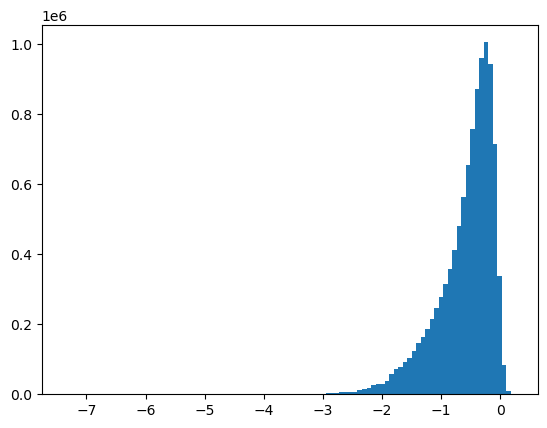

In [73]:
plt.hist(np.log10(1000*era5_uw_ptv_lvl),bins=100)